### Chargement des librairies

In [293]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import feature_selection

sns.set_palette("colorblind")
color_blind_list = sns.color_palette("colorblind", 8)

## Exercice I

### 1)  Chargement des données:

In [13]:
url = 'http://josephsalmon.eu/enseignement/TELECOM/MDI720/datasets/Galton.txt'
df = pd.read_csv(url, sep='\t')

# Arrondi des hauteur à l'unité
df = df.round(0)

# Description rapide du dataset
df.describe()

,Father,Mother,Height,Kids
count,898.000000,898.000000,898.000000,898.000000
mean,69.211581,64.070156,66.747216,6.135857
std,2.479301,2.303257,3.589844,2.685156
min,62.000000,58.000000,56.000000,1.000000
25%,68.000000,63.000000,64.000000,4.000000
50%,69.000000,64.000000,66.000000,6.000000
75%,71.000000,66.000000,70.000000,8.000000
max,78.000000,70.000000,79.000000,15.000000


### 2) Retirer les données manquantes:

In [32]:
# Vérifier s'il y a au moins une valeur manquante
print('Il y a une valeur manquante dans de le dataset:', df.isnull().any().any())

Il y a une valeur manquante dans de le dataset: False


### 3) Visualiser densité de population des pères et des mères

Le dataset contient autant de lignes que d'enfants. Ainsi, pour calculer la densité de population des pères et des mères, il faut dans un premier temps grouper le dataset par famille, avant de calculer un estimateur des différentes densités.

In [90]:
# Regrouper par famille
df_fam = df[['Family', 'Father', 'Mother', 'Kids']].groupby('Family').max()

Grâce à la fonction guassian_kde de la librairie Scipy (note: cela permet de détailler les calculs de la fonction seaborn sns.kdeplot()), nous pouvons calculer un estimateur de la densité de la taille des pères et de la taille des mères:

In [151]:
# Calculer le kernel de la taille des pères et des mères
kernel_Father = stats.gaussian_kde(df_fam['Father'])
kernel_Mother = stats.gaussian_kde(df_fam['Mother'])

# Estimer la densité sur la base des noyaux gaussiens calculés
observations_Father = np.arange(df_fam['Father'].min(),df_fam['Father'].max(), 0.5)
observations_Mother = np.arange(df_fam['Mother'].min(),df_fam['Mother'].max(), 0.5)
estimated_density_Father = kernel_Father(observations_Father)
estimated_density_Mother = kernel_Mother(observations_Mother)

Nous pouvons effectuer la visualisation des deux densités (superposées aux hitogrammes correspondants):

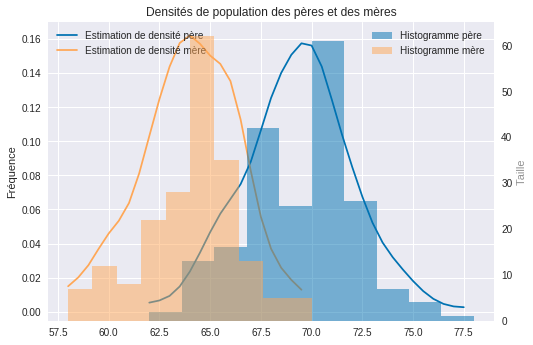

In [152]:
fig, ax1 = plt.subplots()
ax1.plot(observations_Father, estimated_density_Father,
         color=color_blind_list[0], label='Estimation de densité père')
ax1.plot(observations_Mother, estimated_density_Mother,
         color=sns.xkcd_rgb["pale orange"], label='Estimation de densité mère')
ax1.set_ylabel('Fréquence')
plt.legend(loc='upper left')

ax2 = ax1.twinx()

ax2.hist(df_fam['Father'], histtype="stepfilled",
         alpha=0.5, label='Histogramme père')
ax2.hist(df_fam['Mother'], histtype="stepfilled", alpha=0.5,
         label='Histogramme mère', color=sns.xkcd_rgb["pale orange"])
ax2.set_ylabel('Nombre d\'individus', alpha=0.5)
ax2.tick_params('y', color=sns.xkcd_rgb["pale grey"])

plt.grid(None)
plt.legend(loc='upper right')
plt.title('Densités de population des pères et des mères')
plt.show()

Graphiquement, la distribution des tailles sur les deux populations semble gaussienne.

### 4) Afficher la taille du père en fonction de la mère puis la droite de régression:

In [155]:
min(df_fam['Father'].min(), df_fam['Mother'].min())

58

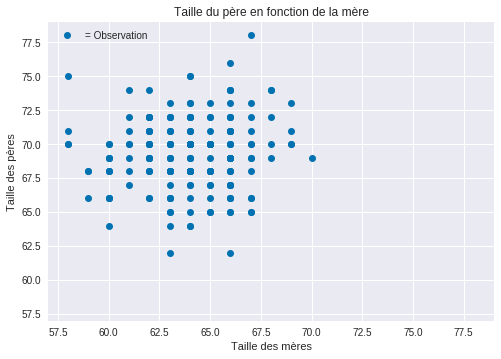

In [164]:
# Etablir les mêmes échelles d'axes pour une meilleure représentation
xmin = min(df_fam['Father'].min(), df_fam['Mother'].min())
xmax = max(df_fam['Father'].max(), df_fam['Mother'].max())
ymin = xmin.copy()
ymax = xmax.copy()

# Plot
fig = plt.figure()
plt.plot(df_fam['Mother'], df_fam['Father'], 'o', label='= Observation')
plt.xlim(xmin-1, xmax+1)
plt.ylim(ymin-1, ymax+1)
plt.xlabel('Taille des mères')
plt.ylabel('Taille des pères')
plt.legend(numpoints=1, loc=2)
plt.title('Taille du père en fonction de la mère')
plt.show()

Du précédent graphique nous pouvons ajouter la droite de régression linéaire en utilisant la librairie Scikit-learn:

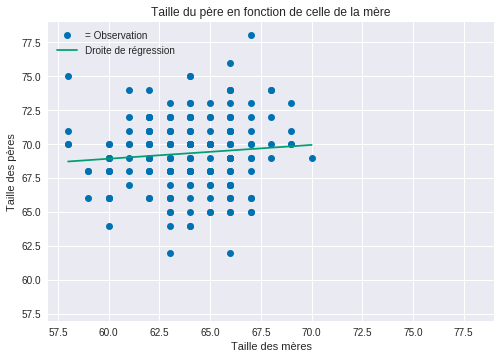

In [165]:
# Fit modèle de régression
skl_linmod = linear_model.LinearRegression()
skl_linmod.fit(df_fam[['Mother']], df_fam['Father'])

# Calculer prédictions pour la visualisation
X_to_predict = np.linspace(df_fam['Mother'].min(), df_fam['Mother'].max(), num=50).reshape(50, 1)
X_to_predict = pd.DataFrame(X_to_predict, columns=['Mother'])
X_predicted = skl_linmod.predict(X_to_predict)

# Ajouter la droite de régression au précédent graphique
fig = plt.figure()
plt.plot(df_fam['Mother'], df_fam['Father'], 'o', label='= Observation')
plt.xlim(xmin-1, xmax+1)
plt.ylim(ymin-1, ymax+1)
plt.plot(X_to_predict, X_predicted, label='Droite de régression')
plt.xlabel('Taille des mères')
plt.ylabel('Taille des pères')
plt.legend(numpoints=1, loc=2)
plt.title('Taille du père en fonction de celle de la mère')
plt.show()

### 5) Afficher un histogramme du nombre d'enfants par famille:

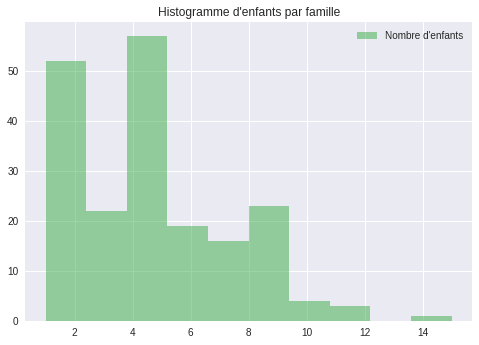

In [92]:
fig = plt.figure()
plt.hist(df_fam['Kids'], histtype="stepfilled",
         alpha=0.5, label='Nombre d\'enfants', color=sns.xkcd_rgb["medium green"])
plt.xlabel('Nombre d\'enfants par famille')
plt.ylabel('Nombre d\'individus par catégorie')
plt.legend()
plt.title('Histogramme d\'enfants par famille')
plt.show()

Graphiquement, il semble que la majorité des familles étudiées a entre 2 et 4 enfants.

### 6) Créer une colonne 'MidParents':

In [94]:
df['MidParents'] = (df['Father'] + 1.08 * df['Mother'])/2
df.head()

,Family,Father,Mother,Gender,Height,Kids,MidParents
0,1,78.0,67.0,M,73.0,4,75.18
1,1,78.0,67.0,F,69.0,4,75.18
2,1,78.0,67.0,F,69.0,4,75.18
3,1,78.0,67.0,F,69.0,4,75.18
4,2,76.0,66.0,M,74.0,4,73.64


### 7) Regression linéaire des tailles des enfants en fonction de la taille moyenne des parents: estimer θ0, θ1, par ˆθ0,ˆθ1 grâce à Scikit-Learn et numériquement:

Calculons grâce à la régression linéaire de Scikit-Learn thêta0_chap et thêta1_chap:

In [102]:
# Fit modèle de régression
skl_linmod = linear_model.LinearRegression()
skl_linmod.fit(df[['MidParents']], df['Height'])
print('Thêta0_chap vaut %s et thêta1_chap vaut %s, d\'après le modèle de régression de Scikit-Learn.'%
      (skl_linmod.intercept_.round(0), skl_linmod.coef_[0].round(2)))

Thêta0_chap vaut 22.0 et thêta1_chap vaut 0.65, d'après le modèle de régression de Scikit-Learn


Calculons numériquement thêta0_chap et thêta1_chap:

In [112]:
θ1 = ((df['MidParents'] - df['MidParents'].mean()) * (df['Height'] - df['Height'].mean())).sum() / (np.square((df['MidParents'] - df['MidParents'].mean()))).sum()
θ0 = df['Height'].mean() - θ1 * df['MidParents'].mean()
print('Thêta0_chap vaut %s et thêta1_chap vaut %s, numériqument.' % (θ0, θ1))

Thêta0_chap vaut 22.043755013147774 et thêta1_chap vaut 0.6459694681010596, numériqument


Vérifions si les deux méthodes donnent des résultats semblables:

In [118]:
print('Les deux méthodes donnent des résultats semblables:', np.isclose(
    [θ0, θ1], [skl_linmod.intercept_, skl_linmod.coef_[0]]).all())

Les deux méthodes donnent des résultats semblables: True


### 8) Visualiser graphiquement la régression linéaire:
Nous pouvons prendre d'abord tout le dataset:

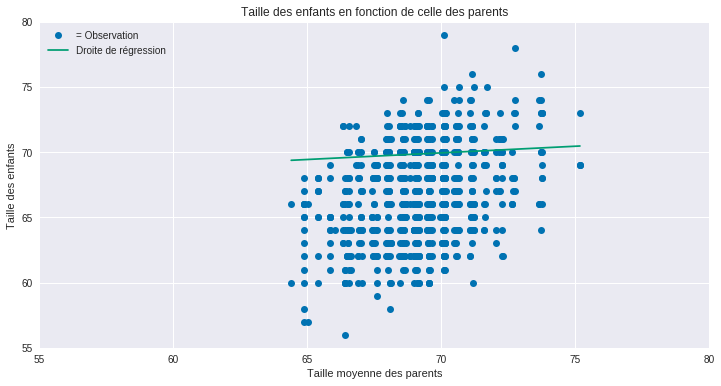

In [170]:
# Etablir les mêmes échelles d'axes pour une meilleure représentation
xmin = min(df['Height'].min(), df['MidParents'].min())
xmax = max(df['Height'].max(), df['MidParents'].max())
ymin = xmin.copy()
ymax = xmax.copy()

# Calculer prédictions pour la visualisation
X_to_predict = np.linspace(df['MidParents'].min(), df['MidParents'].max(), num=50).reshape(50, 1)
X_to_predict = pd.DataFrame(X_to_predict, columns=['MidParents'])
X_predicted = skl_linmod.predict(X_to_predict)

# Ajouter la droite de régression au précédent graphique
fig = plt.figure(figsize=(12, 6))
plt.plot(df['MidParents'], df['Height'], 'o', label='= Observation')
plt.plot(X_to_predict, X_predicted, label='Droite de régression')
plt.xlim(xmin-1, xmax+1)
plt.ylim(ymin-1, ymax+1)
plt.xlabel('Taille moyenne des parents')
plt.ylabel('Taille des enfants')
plt.legend(numpoints=1, loc=2)
plt.title('Taille des enfants en fonction de celle des parents')
plt.show()

Puis opérer deux régressions linéaires sur les deux sous-ensembles fille/garçon:

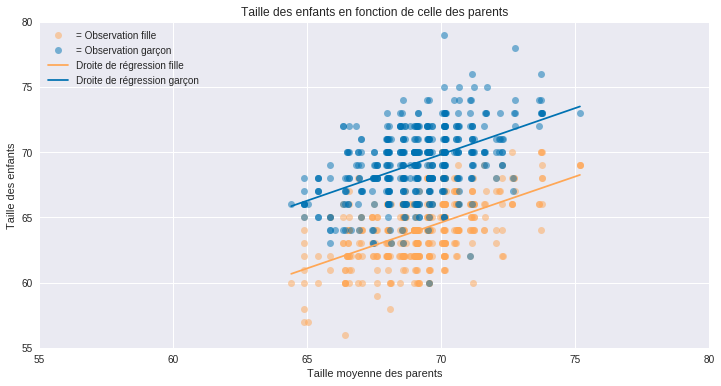

In [178]:
# Fit modèle de régression pour les filles
skl_linmod_F = linear_model.LinearRegression()
skl_linmod_F.fit(pd.DataFrame({'MidParents': df.loc[df.Gender == 'F', 'MidParents']}), # contrainte de skl
                 df.loc[df.Gender == 'F', 'Height'])

# Fit modèle de régression pour les garçons
skl_linmod_M = linear_model.LinearRegression()
skl_linmod_M.fit(pd.DataFrame({'MidParents': df.loc[df.Gender == 'M', 'MidParents']}), # contrainte de skl
                 df.loc[df.Gender == 'M', 'Height'])

# Calculer prédictions pour la visualisation
X_to_predict = np.linspace(df['MidParents'].min()
                           , df['MidParents'].max(), num=50).reshape(50, 1)
X_to_predict = pd.DataFrame(X_to_predict, columns=['MidParents'])
# droite de régression de la taille des filles
X_predicted_F = skl_linmod_F.predict(X_to_predict)
# droite de régression de la taille des garçons
X_predicted_M = skl_linmod_M.predict(X_to_predict)

# Ajouter la droite de régression au précédent graphique
fig = plt.figure(figsize=(12, 6))
plt.plot(df.loc[df.Gender == 'F', 'MidParents'], df.loc[df.Gender == 'F', 'Height'], 'o',
         label='= Observation fille', color=sns.xkcd_rgb["pale orange"], alpha=0.5)

plt.plot(df.loc[df.Gender == 'M', 'MidParents'], df.loc[df.Gender == 'M', 'Height'], 'o',
         label='= Observation garçon', color=color_blind_list[0], alpha=0.5)

plt.plot(X_to_predict, X_predicted_F,
         label='Droite de régression fille', color=sns.xkcd_rgb["pale orange"])

plt.plot(X_to_predict, X_predicted_M,
         label='Droite de régression garçon', color=color_blind_list[0])

plt.xlim(xmin - 1, xmax + 1) # défini dans le précédent graphe
plt.ylim(ymin - 1, ymax + 1) # défini dans le précédent graphe
plt.xlabel('Taille moyenne des parents')
plt.ylabel('Taille des enfants')
plt.legend(numpoints=1, loc=2)
plt.title('Taille des enfants en fonction de celle des parents')
plt.show()

### 9) Visualiser la densité des résidus:
Nous allons d'abord calculer les résidus pour chacune des observations puis en "plotter" la densité grâce à la fonction seaborn sns.kdeplot():

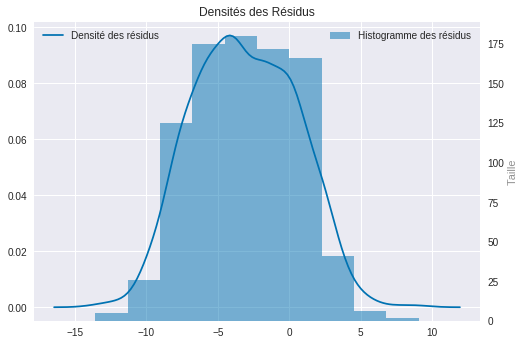

In [184]:
# Calculer les résidus
y_chap = skl_linmod.predict(df[['MidParents']])
df['Residuals'] = df['Height'] - y_chap

# Visualiser un estimateur de la densité des résidus
fig, ax1 = plt.subplots()
ax1 = sns.kdeplot(df['Residuals'], label='Densité des résidus')
plt.legend(loc='upper left')

ax2 = ax1.twinx()

ax2.hist(df['Residuals'], histtype="stepfilled",
         alpha=0.5, label='Histogramme des résidus')
ax2.set_ylabel('Nombre d\'individus', alpha=0.5)
ax2.tick_params('y', color=sns.xkcd_rgb["pale grey"])

plt.grid(None)
plt.legend(loc='upper right')
plt.title('Densités des Résidus')
plt.show()

Dans ces conditions, l'hypothèse de normalité des résidus ne semble pas tenir. Opérons les mêmes manipulations en distinguant les filles des garçons:

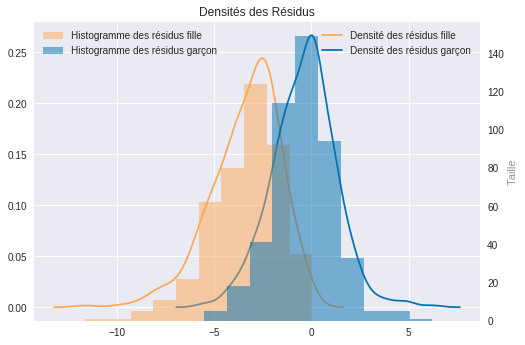

In [199]:
# Calculer les résidus filles
y_chap_F = skl_linmod.predict(pd.DataFrame(
    {'MidParents': df.loc[df.Gender == 'F', 'MidParents']}))
Residuals_F = df.loc[df.Gender == 'F', 'Height'] - y_chap_F

# Calculer les résidus garçon
y_chap_M = skl_linmod.predict(pd.DataFrame(
    {'MidParents': df.loc[df.Gender == 'M', 'MidParents']}))
Residuals_M = df.loc[df.Gender == 'M', 'Height'] - y_chap_M



# Calculer les proportions fille pour chacune des familles
df_F = df.loc[df.Gender == 'F', ['Family', 'Kids']].groupby('Family').agg({'Kids': ['mean', 'count']}) # compter le nombre de filles par famille
df_F['Kids', 'alpha_F'] = df_F['Kids', 'count']/df_F['Kids', 'mean'] # calculer la proportion de fille par famille
alpha = df.loc[df.Gender == 'F', ['Family']].merge(df_F['Kids'], how='left',
                                                   left_on='Family', right_index=True) # ventiller les proportions calculées sur chacune des filles
alpha_F = alpha['alpha_F'] # récupérer les résultats

# Calculer les proportions garçon pour chacune des familles
df_M = df.loc[df.Gender == 'M', ['Family', 'Kids']].groupby('Family').agg({'Kids': ['mean', 'count']}) # compter le nombre de garçons par famille
df_M['Kids', 'alpha_M'] = df_M['Kids', 'count']/df_M['Kids', 'mean'] # calculer la proportion de garçon par famille
alpha = df.loc[df.Gender == 'M', ['Family']].merge(df_M['Kids'], how='left',
                                                   left_on='Family', right_index=True) # ventiller les proportions calculées sur chacune des filles
alpha_M = alpha['alpha_M'] # récupérer les résultats



# Visualiser un estimateur de la densité des résidus
fig, ax1 = plt.subplots()
ax1 = sns.kdeplot(Residuals_F*alpha_F, label='Densité des résidus fille',
                  color=sns.xkcd_rgb["pale orange"])
ax1 = sns.kdeplot(Residuals_M*alpha_M, label='Densité des résidus garçon',
                  color=color_blind_list[0])
plt.legend(loc='upper right')

ax2 = ax1.twinx()

ax2.hist(Residuals_F*alpha_F, histtype="stepfilled",
         color=sns.xkcd_rgb["pale orange"], alpha=0.5, label='Histogramme des résidus fille')

ax2.hist(Residuals_M*alpha_M, histtype="stepfilled",
         color=color_blind_list[0], alpha=0.5, label='Histogramme des résidus garçon')
ax2.set_ylabel('Taille', alpha=0.5)
ax2.tick_params('y', color=sns.xkcd_rgb["pale grey"])

plt.grid(None)
plt.legend(loc='upper left')
plt.title('Densités des Résidus')
plt.show()

Graphiquement, l'hypothèse de normalité semble plus consistante lorsque la population est divisée sur la base du genre.

### 10) Regresser sur la taille des enfants et vérifier une égalité numérique avec les précédents coefficients:
Calculons les coefficients a0_chap et a1_chap les coefficients de la droite de régression de la taille des parents sur celle des enfants grâce à la fonction lienar_model de Scikit-Learn:

In [209]:
# Fit modèle de régression sur la taille des enfants
skl_linmod_reverse = linear_model.LinearRegression()
skl_linmod_reverse.fit(df[['Height']], df['MidParents'])

# Calculer numériquement a0_chap et a1_chap
a0_chap = np.mean(df['MidParents']) + (np.mean(df['Height'])/np.mean(df['MidParents']))*(np.var(df['MidParents'])/np.var(df['Height']))*(θ0 - np.mean(df['Height']))
a1_chap = (np.var(df['MidParents']) / np.var(df['Height']))*θ1

# Vérifier l'égalité numérique
print('Les égalités sont vérifiées numériquement:', np.isclose(
    [a0_chap, a1_chap], [skl_linmod_reverse.intercept_, skl_linmod_reverse.coef_[0]]).all())

Les égalités sont vérifiées numériquement: True


## Exercice II

### 11) Importer les données:

In [217]:
url_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original"
url_names = "https://archive.ics.uci.edu/ml/machinelearning-databases/auto-mpg/auto-mpg.names"
dt = pd.read_csv(url_data, sep="\s+", header=None, names=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"])

D'après la documentation du dataset, ce dernier ne semble pas possèder de marqueur pour les valeurs manquantes. Nous pouvons appliquer .dropna() pour éliminer ces valeurs manquantes:

In [222]:
dt.dropna(inplace=True)

### 12) Calculer l'estimateur des moindres carrés sur les 9 premières lignes:

Nous ne pouvons calculer l'estimateur des moindres carrés que sur la base de variables explicatives numériques (non catégorique). Ainsi, avant de traiter le cas des variables catégoriques, nous concentrerons nos calculs sur les variables 'cylinders', 'displacement','horsepower', 'weight', 'acceleration' et 'model year' pour estimer 'mpg'.

Calculons l'estimateur des moindres carrés et ses prédictions sur les 9 premières lignes dans un premier temps:

In [232]:
# Selectionner les variables explicatives et à expliquer
X_dt_num = dt[['cylinders', 'displacement','horsepower', 'weight', 'acceleration', 'model_year']]
y = dt['mpg']

# Regression linéaire sur les 9 premières lignes
skl_linmod_9 = linear_model.LinearRegression()
skl_linmod_9.fit(X_dt_num[:9], y[:9])

# Calculer les predictions pour les 9 premières lignes
pred_9 = skl_linmod_9.predict(X_dt_num[:9])

# Rassembler les résutlats dans un seul dataFrame
pd.concat([X_dt_num[:9], pd.DataFrame({'mgp': y[:9], 'mpg_pred': pred_9})], axis=1)

,cylinders,displacement,horsepower,weight,acceleration,model_year,mgp,mpg_pred
0,8.0,307.0,130.0,3504.0,12.0,70.0,18.0,17.835934
1,8.0,350.0,165.0,3693.0,11.5,70.0,15.0,16.151352
2,8.0,318.0,150.0,3436.0,11.0,70.0,18.0,17.028033
3,8.0,304.0,150.0,3433.0,12.0,70.0,16.0,16.084149
4,8.0,302.0,140.0,3449.0,10.5,70.0,17.0,17.152477
5,8.0,429.0,198.0,4341.0,10.0,70.0,15.0,14.855885
6,8.0,454.0,220.0,4354.0,9.0,70.0,14.0,14.272661
7,8.0,440.0,215.0,4312.0,8.5,70.0,14.0,14.265870
8,8.0,455.0,225.0,4425.0,10.0,70.0,14.0,13.353638


Nous remarquons que pour les 9 premières lignes du dataset, 'cylinders' et 'model year' sont constantes. Ainsi, 'cylinders' et 'model year' sont inutiles compte tenu du fait que nous avons déjà un intercept. Nous pouvons regarder quels sont les coefficients de l'estimateurs des moindres carrés pour le vérifier:

In [241]:
# Regrouper les noms de coefficients et leur valeur dans un dataFrame
pd.DataFrame(index=X_dt_num.columns.values, data={'coef_value': skl_linmod_9.coef_})

,coef_value
cylinders,0.000000
displacement,0.054088
horsepower,-0.094531
weight,-0.004241
acceleration,-0.199367
model_year,0.000000


Les coefficients sont nulls pour cylinders et model_year, ce qui vérifie notre affirmation.

### 13) Calculer l'estimateur des moindres carrés sur l'ensemble du dataset:

Nous pouvons utiliser les datasets préparés dans la précédente question:

In [242]:
# Regression linéaire sur tout le dataset
skl_linmod = linear_model.LinearRegression()
skl_linmod.fit(X_dt_num, y)

# Calculer les predictions pour les 9 premières lignes
y_chap = skl_linmod.predict(X_dt_num)

# Regrouper les noms de coefficients et leur valeur dans un dataFrame
pd.DataFrame(index=X_dt_num.columns.values, data={'coef_value': skl_linmod.coef_})

,coef_value
cylinders,-0.329859
displacement,0.007678
horsepower,-0.000391
weight,-0.006795
acceleration,0.085273
model_year,0.753367


A la différence de la précédente question, les deux variables qui expliquent le plus la consommation  (celles qui ont le plus grand coefficient en valeur absolue) sont 'cylinders' et 'model year'.

### 14) Calculer le carré de la norme du vecteur des résidus:

In [432]:
# Calculer les résidus
residuals = y - y_chap

# Calculer le carré de la norme 2 des résidus
residuals_norm_square = np.square(np.linalg.norm(residuals, ord=2))

# Calculer la norme 2 des résidus divisée par la différence entre le nombre d'observations et de features
residuals_norm_stand = residuals_norm_square / (len(y) - len(X_dt_num.columns))

# Print des résultats
print('Ainsi, la norme du vecteur des résidus est égal à %s et cette valeur divisée par (n-p) est égal à %s.' %
      (residuals_norm_square.round(0), residuals_norm_stand.round(0)))

Ainsi, la norme du vecteur des résidus est égal à 4543.0 et cette valeur divisée par (n-p) est égal à 12.0.


Vérifier numériquement l'égalité proposée:

In [434]:
# Calculer le membre de gauche et de droite
left = np.square(np.linalg.norm(y-np.mean(y)))
right = residuals_norm_square + np.square(np.linalg.norm(y_chap-np.mean(y)))

# Print des résultats
print('L\'égalité est vérifiée numériquement:', np.isclose(left,right))

L'égalité est vérifiée numériquement: True


### 15) Faire une nouvelle prédiction:

Calculons la consommation du véhicule suivant:
* cylinders 6
* displacement 225
* horsepower 100
* weight 3233
* acceleration 15.4
* year 76

In [281]:
# Initialiser le véhicule à prédire
X_to_predict = pd.DataFrame(data=[[6, 225, 100, 3233, 15.4, 76]], columns=X_dt_num.columns)

# Calculer la prédiction
mpg_pred = skl_linmod.predict(X_to_predict)

# Print du résultat
print('Un tel véhicule devrait consommer %s mpg' % mpg_pred[0].round(0))

Un tel véhicule devrait consommer 22.0 mpg


### 16) Ajuster un modèle d'ordre 2:

Appliquons la transformation PolynomialFeatures de sklearn, puis normalisons les données avec StandardScaler de sklearn:

In [291]:
# Utiliser PolynomialFeatures
poly = preprocessing.PolynomialFeatures(2)
X_dt_num_poly = poly.fit_transform(X_dt_num)

# Standardiser les données obtenus
scaler = preprocessing.StandardScaler()
X_dt_num_poly_stand = scaler.fit_transform(X_dt_num_poly)

Pour déterminer la variable la plus explicative, nous mesurons la p-value des coefficients de chacune des variables explicatives prise une à une pour prédire y. Pour cela, nous utiliserons la fonction f_regression de sklearn:

In [339]:
y_stand = (y - np.mean(y)) / np.std(y) # standardizer y également
pvals = feature_selection.f_regression(X_dt_num_poly_stand, y_stand, center=False)[
    1]  # les pvals sont en seconde position

Grâce à cette méthode, nous pouvons repérer le plus petit élément de pval et donc repérer le coefficient dont la probabilité de rejeter l'hypothèse nulle est la plus forte. La liste des features est récupérable grâce à la méthode get_feature_names de PolynomialFeatures, ainsi:

In [338]:
print('La variable qui explique le plus la consommation dans le cadre d\'une régression polynomiale, est:',
      np.array(poly.get_feature_names(X_dt_num.columns))[np.array(pvals) == np.nanmin(np.array(pvals))][0])

La variable qui explique le plus la consommation dans le cadre d'une régression polynomiale, est: weight


### 17) Gérer la variable origin:

La variable origin a été retirée initialement car il s'agit d'une variable catégorielle. Pour l'intégrer au modèle, nous devons préalablement la "dummyfier", la convertir en dummy variable grâce à pd.get_dummies:

In [341]:
# Utiliser pd.get_dummies sur origin
X_dt_wOrigin = dt[['cylinders', 'displacement','horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
X_dt_wOrigin_dummy = pd.get_dummies(X_dt_wOrigin, prefix='origin', columns=['origin'])

# Visualiser les premières lignes ainsi obtenues
X_dt_wOrigin_dummy.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_1.0,origin_2.0,origin_3.0
0,8.0,307.0,130.0,3504.0,12.0,70.0,1,0,0
1,8.0,350.0,165.0,3693.0,11.5,70.0,1,0,0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1,0,0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1,0,0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1,0,0


De là, nous pouvons appliquer un modèle de régression linéaire, sans constante, et comparer les coefficients de régression des trois origines (les valeurs étant de zéro ou un pour les trois origines, avec un un seulement pour une des trois à chaque ligne, les coefficients correspondant mesurent l'incrément sur la consommation total qu'il y a à connaître le pays d'origine du modèle):

In [344]:
# Regression linéaire sur le nouveau dataset, sans constante
skl_linmod_wOrigin = linear_model.LinearRegression(fit_intercept=False)
skl_linmod_wOrigin.fit(X_dt_wOrigin_dummy, y)

# Regrouper les noms de coefficients et leur valeur dans un dataFrame
pd.DataFrame(index=X_dt_wOrigin_dummy.columns.values, data={'coef_value': skl_linmod_wOrigin.coef_})

,coef_value
cylinders,-0.489709
displacement,0.023979
horsepower,-0.018183
weight,-0.006710
acceleration,0.079103
model_year,0.777027
origin_1.0,-17.954602
origin_2.0,-15.324600
origin_3.0,-15.101374


Du tableau précédent, il apparaît que je Japon (code 3) est le plus efficace en terme de consommation (maximise la mesure "miles per gallon").

### 18) Intégrer la marque au modèle de régression:

Tout d'abord, nous devons récupérer la marque des données brutes. Pour ce faire, il semble qu'il faille l'extraire du nom du véhicule. En effet, chaque nom de véhicule commence par le nom de la marque. Ainsi, nous pouvons créer la nouvelle feature marque comme quit:

In [354]:
dt['brand'] = dt['car_name'].str.replace("\s.*", "")

Ensuite, comme précedemment, nous pouvons "dummyfier" la marque, appliquer une régression linéaire aux données et récupérer les coefficients pour déterminer quelle marque est la plus efficace (d'après la même méthodologie que précédemment) au regard de la consommation:

In [429]:
# Utiliser pd.get_dummies sur origin
X_dt_wBrand = dt[['cylinders', 'displacement', 'horsepower',
                  'weight', 'acceleration', 'model_year', 'brand']]
X_dt_wBrand_dummy = pd.get_dummies(X_dt_wBrand, columns=['brand'])

# Regression linéaire sur le nouveau dataset, sans constante
skl_linmod_wBrand = linear_model.LinearRegression(fit_intercept=False)
skl_linmod_wBrand.fit(X_dt_wBrand_dummy, y)

# Regrouper les noms de coefficients et leur valeur dans un dataFrame
res = pd.DataFrame(index=X_dt_wBrand_dummy.columns.values,
                   data={'coef_value': skl_linmod_wBrand.coef_})
res_brand = res[res.index.str.contains('brand')] # sélectionner seulement les colonnes marque
print("La marque la plus efficace au sens de la consommation est:",
      res_brand[res_brand.coef_value == max(res_brand.coef_value)].index.str.split('_')[0][1])

La marque la plus efficace au sens de la consommation est: vw


### 19) Obtenir numériquement la SVD de X:

La librairie numpy permet de calculer numériquement la décomposition SVD:

In [386]:
# Récupérer les matrices de décomposition SVD
U, s, V = np.linalg.svd(X_dt_num, full_matrices=False)

Montrons numériquement que UU.T est un projecteur orthogonal, à savoir qu'elle est idempotente et qu'elle est symétrique:

In [412]:
# Definir le projecteur orthogonal
H = U.dot(U.T)

# Montrer l'idempotence
idem = np.isclose(H.dot(H), H).all()

# Montrer la symétrie
sym = np.isclose(H, H.T).all()

# Print du résultat
print("UU.T est un projecteur orthogonal sur l'espace engendré par les lignes:", idem*sym)

UU.T est un projecteur orthogonal sur l'espace engendré par les lignes: True


### 20) Vecteur des leviers:

La diagonale de H est appelé vecteur des leviers. Récupérons ces leviers pour les ajouter comme nouvelle variable:

In [428]:
# Récupérer le vecteur des leviers
vect_lev = np.diag(H)

# Ajouter à la matrice initiale
dt_lev = pd.concat([dt.reset_index(drop=True), pd.DataFrame({'leverage': vect_lev})], axis=1)
dt_lev.sort_values(by='leverage', ascending=False).head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,brand,leverage
13,14.0,8.0,455.0,225.0,3086.0,10.0,70.0,1.0,buick estate wagon (sw),buick,0.186476
28,9.0,8.0,304.0,193.0,4732.0,18.5,70.0,1.0,hi 1200d,hi,0.080754
8,14.0,8.0,455.0,225.0,4425.0,10.0,70.0,1.0,pontiac catalina,pontiac,0.061674


Je ne sais pas en quoi ces modèles sont atypiques.